In [2]:
import pandas as pd
import numpy as np

# Data import

FE = 0 # Feature Engineering (0 = No, 1 = Yes)
Out = 0 # Outliers Processing (0 = No, 1 = Yes)
FR = 0 # Feature Reduction (0 = No, 1 = Yes)

def dataset(FE, Out, FR):
    if FR == 0:
        if FE == 0:
            if Out == 0:
                X_train = pd.read_csv('data/X_train.csv') # Training data
            else:
                X_train = pd.read_csv('data/X_train_out.csv')
            X_test = pd.read_csv('data/X_test.csv') # Test data
        else:
            if Out == 0:
                X_train = pd.read_csv('data/X_train_FE.csv')
            else:
                X_train = pd.read_csv('data/X_train_FE_out.csv')
            X_test = pd.read_csv('data/X_test_FE.csv') # Test data
    else:
        X_train = pd.read_csv('data/X_train_FR.csv')
        X_test = pd.read_csv('data/X_test_FR.csv') # Test data
    
    return X_train, X_test


# Training datasets performance

In [20]:
best ={'colsample_bytree': 0.723028675585211, 
       'learning_rate': 0.04124336649185381, 
       'max_depth': 11, 
       'min_child_samples': 64, 
       'n_estimators': 225, 
       'num_leaves': 57, 
       'reg_alpha': 0.6633304341560168, 
       'reg_lambda': 0.1462724496785454, 
       'subsample': 0.8214969245824829}

In [3]:
Train_sets = {'Normal dataset': [0, 0, 0], 'Normal dataset without outliers': [0, 1, 0], 
              'Dataset With FE': [1, 0, 0], 'Dataset With FE without outliers': [1, 1, 0],
              'Dataset With FE and FR': [1, 1, 1]}

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

Scores = {}

for name, model in Train_sets.items():
    X_train, X_test  = dataset(model[0], model[1], model[2])
    y_train = X_train['Age']
    X_train = X_train.drop(['Age'], axis=1)
    model_LGBM = lgb.LGBMRegressor(**best)                   
    mae = cross_val_score(model_LGBM, X_train, y_train, cv=10, scoring=make_scorer(mean_absolute_error)).mean()
    print("Name:", name, "MAE:", mae)
    print('')   

Name: Normal dataset MAE: 1.397278115537058

Name: Normal dataset without outliers MAE: 1.3000444477616278

Name: Dataset With FE MAE: 1.3968632709343933

Name: Dataset With FE without outliers MAE: 1.3968632709343933

Name: Dataset With FE and FR MAE: 1.423610375240086



# LightGBM model training

## Step 1: Split Train a test datasets by outliers presence

In [11]:
# Data import 
X_train, X_test  = dataset(0, 0, 0)

In [12]:
SD = 3 # Standard Deviation

X_test_normal = X_test.copy()
X_test_out = pd.DataFrame()

for col in X_test.columns[1:]:
    # Define the condition for a value to be considered as an outlier
    condition = (X_test_normal[col] < X_test_normal[col].mean() - SD * X_test_normal[col].std()) | (X_test_normal[col] > X_test_normal[col].mean() + SD * X_test_normal[col].std())
    
    # Add outliers to X_test_out
    X_test_out = pd.concat([X_test_out, X_test_normal[condition]])
    
    # Remove outliers from X_test_normal
    X_test_normal = X_test_normal[~condition]

# The same for X_train
X_train_normal = X_train.copy()
X_train_out = pd.DataFrame()

for col in X_train.columns[1:]:

    condition = (X_train_normal[col] < X_train_normal[col].mean() - SD * X_train_normal[col].std()) | (X_train_normal[col] > X_train_normal[col].mean() + SD * X_train_normal[col].std())
    
    X_train_out = pd.concat([X_train_out, X_train_normal[condition]])
    
    X_train_normal = X_train_normal[~condition]

In [13]:
# Print shapes of datasets
print('X_test_normal shape: ', X_test_normal.shape)
print('X_test_out shape: ', X_test_out.shape)
print('X shape: ', X_test.shape)

print('X_train_normal shape: ', X_train_normal.shape)
print('X_train_out shape: ', X_train_out.shape)
print('X_train shape: ', X_train.shape)

X_test_normal shape:  (48584, 10)
X_test_out shape:  (784, 10)
X shape:  (49368, 10)
X_train_normal shape:  (72036, 11)
X_train_out shape:  (2015, 11)
X_train shape:  (74051, 11)


## Step 2: Modelling 

### LightGBM hyper-parameter tunning

In [14]:
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error

In [15]:
X_train_LGBM = X_train.copy()

y_train_LGBM = X_train['Age']
X_train_LGBM.drop(['Age'], axis=1, inplace=True)

In [16]:
space ={
    'max_depth': hp.quniform('max_depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.015, 0.07),
    'num_leaves': hp.quniform('num_leaves', 5, 100, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1.0),
    'subsample': hp.uniform('subsample', 0.01, 1.0),
    'n_estimators': hp.quniform('n_estimators', 20, 300, 5),
    'min_child_samples': hp.quniform('min_child_samples', 2, 100, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)
}

def objective(space):
    model_LGBM = lgb.LGBMRegressor(max_depth = int(space['max_depth']),
                             learning_rate = space['learning_rate'],
                             num_leaves = int(space['num_leaves']),
                             n_estimators = int(space['n_estimators']),
                             colsample_bytree = space['colsample_bytree'],
                             subsample = space['subsample'],
                             min_child_samples = int(space['min_child_samples']),
                             reg_alpha = space['reg_alpha'],
                             reg_lambda = space['reg_lambda'])
    
                             
    mae = cross_val_score(model_LGBM, X_train_LGBM, y_train_LGBM, cv=5, scoring=make_scorer(mean_absolute_error)).mean()

    return {'loss': mae, 'status': STATUS_OK}


# Run the algorithm
trials = Trials()
best_LGBM = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=1200,
            trials=trials)

print("Best: ", best_LGBM)


  2%|▏         | 20/1200 [00:39<38:41,  1.97s/trial, best loss: 1.400377448575854]


KeyboardInterrupt: 

In [27]:
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['n_estimators'] = int(best['n_estimators'])
best['min_child_samples'] = int(best['min_child_samples'])

model_LGBM = lgb.LGBMRegressor(**best)

### Modelling no outliers observations of test

In [18]:
y_train_norm = X_train_normal['Age']
X_train_norm = X_train_normal.drop(['Age'], axis=1)

In [21]:
model_LGBM = lgb.LGBMRegressor(**best)                   
mae = cross_val_score(model_LGBM, X_train_norm, y_train_norm, cv=10, scoring=make_scorer(mean_absolute_error)).mean()
print("MAE:", mae)

MAE: 1.3000444477616278


In [24]:
y_pred_normal = model_LGBM.fit(X_train_norm, y_train_norm).predict(X_test_normal)
y_pred_normal = pd.DataFrame(y_pred_normal, columns=['Age'])

In [25]:
# Concatenate y_pred_normal and X_test_normal
y_pred_new = pd.DataFrame(data=y_pred_normal.values, index=X_test_normal.index, columns=y_pred_normal.columns)
X_test_n = pd.concat([X_test_normal,y_pred_new], axis=1)

#### Solution analysis

In [26]:
y_pred_normal_train = model_LGBM.fit(X_train_norm, y_train_norm).predict(X_train_norm)
Error = (y_train_norm - y_pred_normal_train).to_frame(name='Error')
y_pred_normal_train = pd.DataFrame(y_pred_normal_train, columns=['Age_pred'])

In [27]:
y_pred_normal_train = pd.DataFrame(data=y_pred_normal_train.values, index=X_train_normal.index, columns=y_pred_normal_train.columns)

In [28]:
X_train_No_outliers = pd.concat([X_train_normal, y_pred_normal_train, Error], axis=1)

In [29]:
X_train_No_outliers.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M,Age_pred,Error
0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,0,1,0,10.703759,-1.703759
1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,0,1,0,7.934830,0.065170
2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,0,0,1,9.230964,-0.230964
3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1,0,0,13.051829,-2.051829
4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,0,1,0,8.724423,-0.724423


### Modelling outliers observations of test

In [33]:
y_train_norm = X_train_out['Age']
X_train_norm = X_train_out.drop(['Age'], axis=1)
y_train_norm = y_train_norm.squeeze()

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb


y_train_at = X_train['Age']
X_train_at = X_train.drop(['Age'], axis=1)
mae = cross_val_score(model_LGBM , X_train_norm, y_train_norm, cv=10, scoring=make_scorer(mean_absolute_error)).mean()
print("MAE:", mae)

MAE: 1.943829647000522


In [54]:
y_pred_aty = model_LGBM.fit(X_train_at, y_train_at).predict(X_test_out)

In [37]:
y_A = pd.DataFrame(y_pred_aty, columns=['Age'])

In [38]:
y_A_new = pd.DataFrame(data=y_A.values, index=X_test_out.index, columns=y_A.columns)
X_test_aty = pd.concat([X_test_out, y_A_new], axis=1).sort_index()

#### Solution analysis

In [41]:
X_train_out2 = X_train_out.drop(['Age'], axis=1)

y_pred_out_train = np.round(model_LGBM.fit(X_train_out2, X_train_out['Age']).predict(X_train_out2),0)
Error_out = (X_train_out['Age'] - y_pred_out_train).to_frame(name='Error')

In [44]:
y_pred_out_train = pd.DataFrame(y_pred_out_train, columns=['Age_pred'])

In [45]:
X_train_out = X_train_out.reset_index(drop=True)
y_pred_out_train = y_pred_out_train.reset_index(drop=True)
Error_out = Error_out.reset_index(drop=True)

X_train_outliers = pd.concat([X_train_out, y_pred_out_train, Error_out], axis=1)

In [46]:
X_train_No_outliers = X_train_No_outliers.reset_index(drop=True)
X_train_outliers = X_train_outliers.reset_index(drop=True)

X_train_analysis = pd.concat([X_train_No_outliers, X_train_outliers], axis=0)

In [47]:
X_train_analysis.to_csv('data/X_train_analysis.csv', index=False)
X_train_No_outliers.to_csv('data/X_train_analysisNO.csv', index=False)
X_train_outliers.to_csv('data/X_train_analysisO.csv', index=False)

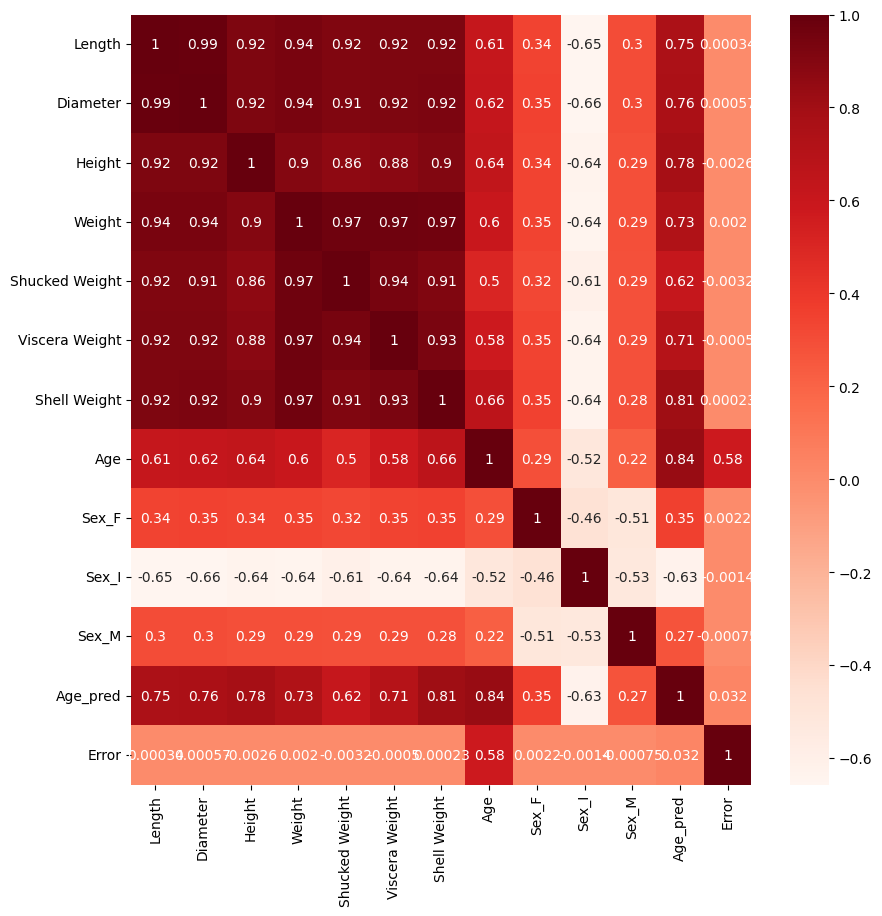

In [48]:
# Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr = X_train_analysis.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

## Concatenate X_test_normal and X_test_out 

In [49]:
# Concatenate X_test_normal and X_test_out keeping previous order
X_test_final = pd.concat([X_test_n, X_test_aty]).sort_index()

# Submission

In [50]:
X_test_submission = pd.read_csv('input/test.csv') # Test data
id_test = X_test_submission['id']

In [51]:
y_pred = X_test_final['Age']
y_pred

0         7.530991
1         7.756053
2        10.694841
3         9.617218
4         7.438604
           ...    
49363     9.444966
49364     8.031927
49365    13.013418
49366    10.077542
49367    12.106629
Name: Age, Length: 49368, dtype: float64

In [52]:
# Submission to a file
# Rounded pred increases the score
submission = pd.DataFrame({'id': id_test, 'Age': np.round(y_pred,0)})
submission.to_csv('submission.csv', index=False)